题目：手写数字识别

原始数据集的标签 y yy 取值为1到10，y=10 y=10y=10表示当前手写字为0，其余1到9即对应1到9。

数据集保存在 ex3data1.mat，注意文件格式跟之前不一样，用matlab打开可以看到有X XX和y yy两个变量：

X XX的维度是5000×400，表示有5000个样本，每个样本有400个特征（其实就是20×20的像素值）

y yy的维度是5000×1，表示有5000个样本，每个样本对应1个标签（1到10共十种标签值，每种标签有500个样本）

## 1.导入数据

1.导入库与数据集：

In [108]:
import numpy as np                # 科学计算库，处理多维数组，进行数据分析
import matplotlib.pyplot as plt   # 提供一个类似 Matlab 的绘图框架
import scipy.io as sio            # 数据输入输出，用于读入.mat文件。scipy一个高级的科学计算库，它和Numpy联系很密切

data = sio.loadmat('ex3data1.mat')

2.查看数据类型

In [130]:
print(type(data))
print(data)
print(data.keys())

<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


3.手写数字图像可视化：由于导入的data是字典类型，因此用键值来获取X并打印出图像

In [110]:
raw_X = data['X']   # raw_X 维度是(5000,400)
raw_y = data['y']   # raw_y 维度是(5000,1)

print(raw_X.shape,raw_y.shape)

(5000, 400) (5000, 1)


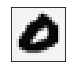

In [111]:
# 打印一张图片的函数
def plot_an_image(X):
    
    pick_one = np.random.randint(5000)
    
    image = X[pick_one,:]
    
    fig,ax = plt.subplots(figsize=(1,1))
    ax.imshow(image.reshape(20,20).T,cmap = 'gray_r')
    
    plt.xticks([])
    plt.yticks([])
    
plot_an_image(raw_X)

(100, 400)


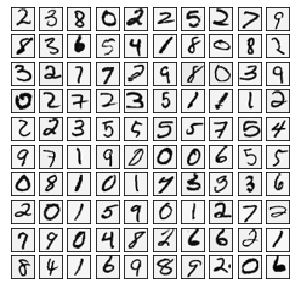

In [112]:
def plot_100_image(X):
    sample_index = np.random.choice(len(X),100)#从样本集中随机选取100个打印
    images = X[sample_index,:]#选取该行，所有列（即对应一个样本）   	
    print(images.shape)
    # 创建绘图实例
    fig,ax = plt.subplots(ncols=10,nrows=10,figsize=(5,5),  #10×10共100张图，总窗口大小为5×5
                          sharex=True,sharey=True)         #所有图像共享x,y轴属性
    plt.xticks([]) #隐藏x,y轴坐标刻度
    plt.yticks([])

    # 循环 10*10 共100次，打印100张图片
    for r in range(10):#行
        for c in range(10):#列
            ax[r,c].imshow(images[10 * r + c].reshape(20,20).T,cmap='gray_r')
        
    plt.show
    
plot_100_image(raw_X)

## 2.使用scipy优化函数

之前的两次作业中，在定义代价函数和梯度下降函数后，我们都是手动定义学习率alpha和梯度下降的迭代次数iters来得到最终优化的参数集θ。

我们利用scipy库中的一个优化函数来自动优化模型参数，该函数可以根据输入的参数 返回最终优化的参数集，其定义如下如下：

scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, 
callback=None, options=None)

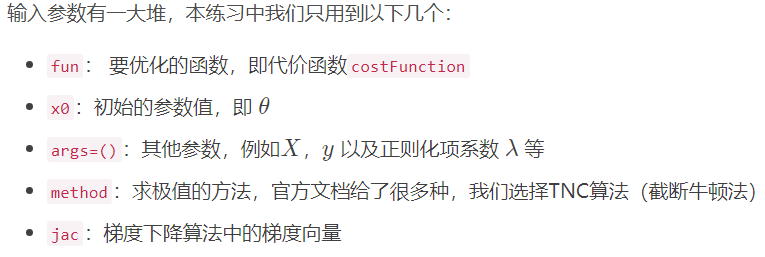

1.构造数据集

In [113]:
X = np.insert(raw_X,0,values=1,axis=1)  # 在首列插入x0=1的一列。axis=1表示按列插入
y = raw_y.flatten()                      # 使得到的 y为一维数组

可以用 X.shape 和y.shape 查看数组的维度 ，维度分别为(5000,401)和(5000,)

In [114]:
print(X.shape)
print(y.shape)

(5000, 401)
(5000,)


2.定义代价函数

In [115]:
# 定义逻辑函数
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [116]:
# 定义代价函数
def costFunction(theta,X,y,lamda):
    A = sigmoid(X@theta)    # 假设函数
    
    first = y*np.log(A)
    second = (1-y) * np.log(1-A)
    
    # reg = np.sum(np.power(theta[1:],2)) * (lamda / (2 * len(X)))
    reg = theta[1:] @ theta[1:] * (lamda / (2 * len(X)))
    return -np.sum(first + second ) / len(X) + reg   

3.定义梯度向量（带正则项）
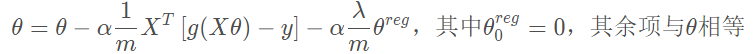

In [117]:
def gradient_reg(theta,X,y,lamda):
    reg = theta[1:] * (lamda / len(X))
    reg = np.insert(reg,0,values=0,axis=0)
    
    first = (X.T@(sigmoid(X@theta) - y)) / len(X)
    
    return first + reg    # 注意返回的是一个向量，维度与 theta一致

4.定义优化函数
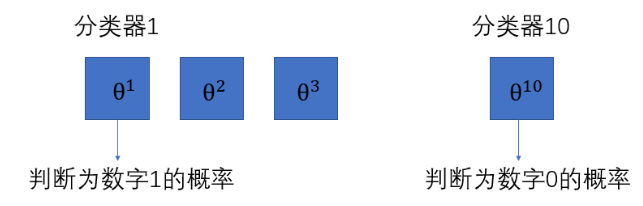

In [118]:
# 定义优化函数（不太会）
from scipy.optimize import minimize

def one_vs_all(X,y,lamda,K):          # K为标签个数
    
    n = X.shape[1]                    # 特征数量，本例中为 401
    
    # 总的参数向量维度是K×n(本例中为10×401)，相当于构建了K个分类器，每个分类器最后都会得到一个优化参数集
    theta_all = np.zeros((K,n))
    
    for i in range(1,K+1):
        theta_i = np.zeros(n,)        # 第 i个分类器的参数集
        
        res = minimize(fun =costFunction,
                      x0 = theta_i,
                      args = (X, y == i,lamda),  # y==i表示当前分类器需要判别 y属于哪个标签值
                      method = 'TNC',
                      jac =gradient_reg )
        theta_all[i-1,:] = res.x                 # 表示当前分类器的最优 θ
        
    return theta_all                  # 将K个分类器的优化结果保存在theta_all

## 3.计算分类准确率

1.给正则化系数lamda和分类器个数K赋上初值，来查看下最终的优化参数：

In [119]:
# 假设参数
lamda  = 1
K =10

# 学习得到最优化参数theta_final
theta_final = one_vs_all(X,y,lamda,K)

In [120]:
print(theta_final)
print(theta_final.shape)

[[-2.38256082e+00  0.00000000e+00  0.00000000e+00 ...  1.30444492e-03
  -7.57440574e-10  0.00000000e+00]
 [-3.18411901e+00  0.00000000e+00  0.00000000e+00 ...  4.45899412e-03
  -5.08382243e-04  0.00000000e+00]
 [-4.79710384e+00  0.00000000e+00  0.00000000e+00 ... -2.87015619e-05
  -2.47369084e-07  0.00000000e+00]
 ...
 [-7.98858703e+00  0.00000000e+00  0.00000000e+00 ... -8.94373037e-05
   7.21264496e-06  0.00000000e+00]
 [-4.57128851e+00  0.00000000e+00  0.00000000e+00 ... -1.33684511e-03
   9.99803054e-05  0.00000000e+00]
 [-5.40385522e+00  0.00000000e+00  0.00000000e+00 ... -1.16431667e-04
   7.83775900e-06  0.00000000e+00]]
(10, 401)


2.由于本例的样本是图像，无法像上一个那样通过绘图就可以大概看出分类的准确率，只能靠计算得出：

In [121]:
def predict(X,theta_final):
    
    # 5000个样本，每个样本都有10个预测输出（概率值）
    h = sigmoid(X@theta_final.T) #(5000,401) (10,401) =>(5000,10)
    
    # 每个样本取自己10个预测中最大的值作为最终预测值
    h_argmax = np.argmax(h,axis=1)
    
    return h_argmax + 1  # 返回列索引为0表示标签值为1，返回列索引为9表示标签值为10（代表数字0）

In [122]:
y_pre = predict(X,theta_final)
acc = np.mean(y_pre == y)
print(acc)      # 得分
print(y_pre)    # 预测数据
print(y)        # 实际标签

0.9446
[10 10 10 ...  9  9  7]
[10 10 10 ...  9  9  9]


模型训练完成（ending...）

## 试验一下

(1237, 879, 3)


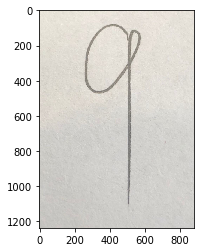

In [123]:
# 导入图片
import matplotlib.image as mpimg # mpimg 用于读取图片

data_test = mpimg.imread('test.png',0)
print(data_test.shape )
plt.imshow(data_test)
plt.show()

In [124]:
# 保存为 mat 格式
import glob
import os
import numpy as np
from PIL import Image
import scipy.io as io
 
save_dir = 'test.png'
#file_list = glob.glob(src_dir+'*.jpg')  # get name list of all .png files    
print('Start...')
# initrialize
 
img = Image.open('test.png')
# save to .npy
res = np.array(img, dtype='uint16')
print('Saving data...')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
np.save(save_dir+'origin.npy', res)
print('Done.')
 
numpy_file = np.load('test.pngorigin.npy')
 
io.savemat('test1.mat',{'data':numpy_file})

Start...
Saving data...
Done.


In [125]:
# 读取 mat 格式的图片
data1 = sio.loadmat('test1.mat')
print(data1)

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Fri Jul  3 16:04:31 2020', '__version__': '1.0', '__globals__': [], 'data': array([[[240, 236, 225],
        [241, 237, 226],
        [242, 238, 227],
        ...,
        [237, 230, 222],
        [236, 229, 221],
        [234, 227, 219]],

       [[240, 236, 225],
        [240, 236, 225],
        [241, 237, 226],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [236, 229, 221]],

       [[239, 235, 224],
        [239, 235, 224],
        [240, 236, 225],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [237, 230, 222]],

       ...,

       [[194, 193, 189],
        [194, 193, 189],
        [192, 191, 187],
        ...,
        [204, 203, 201],
        [204, 203, 201],
        [203, 202, 200]],

       [[196, 195, 191],
        [195, 194, 190],
        [194, 193, 189],
        ...,
        [204, 203, 201],
        [204, 203, 201],
        [203, 202, 200]],

       [[198, 197, 193]

In [129]:
print(data1.keys())
print(data1.values())

dict_keys(['__header__', '__version__', '__globals__', 'data'])
dict_values([b'MATLAB 5.0 MAT-file Platform: nt, Created on: Fri Jul  3 16:04:31 2020', '1.0', [], array([[[240, 236, 225],
        [241, 237, 226],
        [242, 238, 227],
        ...,
        [237, 230, 222],
        [236, 229, 221],
        [234, 227, 219]],

       [[240, 236, 225],
        [240, 236, 225],
        [241, 237, 226],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [236, 229, 221]],

       [[239, 235, 224],
        [239, 235, 224],
        [240, 236, 225],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [237, 230, 222]],

       ...,

       [[194, 193, 189],
        [194, 193, 189],
        [192, 191, 187],
        ...,
        [204, 203, 201],
        [204, 203, 201],
        [203, 202, 200]],

       [[196, 195, 191],
        [195, 194, 190],
        [194, 193, 189],
        ...,
        [204, 203, 201],
        [204, 203, 201],
        [203, 202, 200]],


In [132]:
raw_X1 = data1['data']
print(raw_X1.shape)

(1237, 879, 3)


In [134]:
X1 = np.insert(raw_X1,0,values=1,axis=1)
print(X1.shape)

(1237, 880, 3)


In [135]:
y_pred1 = predict(X1,theta_final)
print(y_pred1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 401 is different from 3)

接下来不会了，回头继续接着做。。。（1.改变为矩阵形式(卡住了,为什么矩阵的维数会不对呢？？？) 2.放入训练好的模型中 3.输出y_pred）